# Text modeling
- Explore and pre-process text
- Train generic embeddings with Google News corpus
- Use Word2Vec to create vectors from project blurb
- Test model somehow

In [1]:
# Import packages

import numpy as np
import pandas as pd
import csv
import numpy as np
import scipy
import six
import smart_open as so

In [3]:
# Read in df
df = pd.read_pickle('concat_df.pkl')

In [4]:
df.head()

,id,name,blurb,goal,pledged,state,country,currency_symbol,deadline,state_changed_at,...,staff_pick,backers_count,location.id,location.name,category.id,category.name,category.slug,spotlight,urls.web.project,run_id
0,287514992,New Final Round Album,2006 was almost 7 years ago.... Can you believ...,200.0,802.0,successful,US,$,1391899046,1391899046,...,False,21,2379574.0,Chicago,43,Rock,music/rock,True,https://www.kickstarter.com/projects/149592564...,Kickstarter_2019-03-14T03_20_12_200Z
1,385129759,Princess Pals Enamel Pin Series,An adorable fantasy enamel pin series of princ...,400.0,2259.0,successful,US,$,1551801611,1551801611,...,False,97,2486340.0,Sacramento,54,Mixed Media,art/mixed media,True,https://www.kickstarter.com/projects/freckledd...,Kickstarter_2019-03-14T03_20_12_200Z
2,681033598,Their Life Through Their Lens-the Amish and Me...,Helping a community come together to set the s...,27224.0,29638.0,successful,US,$,1480607930,1480607932,...,True,88,2383660.0,Columbus,280,Photobooks,photography/photobooks,True,https://www.kickstarter.com/projects/119685626...,Kickstarter_2019-03-14T03_20_12_200Z
4,904085819,Apple Watch Development Course,Learn to build 10+ Applications in this comple...,1000.0,549.0,failed,US,$,1428511017,1428511019,...,False,20,2479651.0,Redmond,51,Software,technology/software,False,https://www.kickstarter.com/projects/187084538...,Kickstarter_2019-03-14T03_20_12_200Z
6,1136128624,Quickstarter: Tao Of Maceo,Tao Of Maceo is a professionally printed journ...,850.0,886.0,successful,US,$,1534791600,1534791602,...,False,15,2442047.0,Los Angeles,48,Nonfiction,publishing/nonfiction,True,https://www.kickstarter.com/projects/maceopais...,Kickstarter_2019-03-14T03_20_12_200Z


In [5]:
df = df.reset_index(drop=True)

## Pre-process text field
- lowercase
- remove punctuation
- tokenize

In [2]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
import string
import re

In [9]:
type(df['blurb'])

pandas.core.series.Series

In [7]:
df['blurb'] = df['blurb'].astype(str)

In [13]:
type(df['blurb'][0])

str

In [14]:
# Define a function that cleans strings: lowercase, remove select punctuation, tokenize
def clean_text(my_str):
    str_low = my_str.lower()
    remove = string.punctuation
    remove = remove.replace(".", " ").replace(",", " ").replace("'", " ")
    pattern = r"[{}]".format(remove) # create the pattern
    cleanstr = re.sub(pattern, " ", str_low)
    finalword = word_tokenize(cleanstr)
    return finalword

In [25]:
# Define a function that strips all punctuation and stop words
def stripper(my_str):
    str_low = my_str.lower()
    allpunc = string.punctuation
    pattern = r"[{}]".format(allpunc) # create the pattern
    cleanstr = re.sub(pattern, " ", str_low)
    tokenword = word_tokenize(cleanstr)
    cleanstr = [word for word in tokenword if word not in stopwords.words('english')]
    return cleanstr

In [17]:
# Call functions on blurb to clean the text
# Will want to call both functions to create 2 versions and 2 df

clean_blurb = []

for i in df['blurb']:
    cleaned = clean_text(i)
    clean_blurb.append(cleaned)

In [18]:
len(clean_blurb)

1668216

In [19]:
df['cleanblurb'] = clean_blurb

In [ ]:
df.sample(3)

In [ ]:
strip_blurb = []

for i in df['blurb']:
    stripped = stripper(i)
    strip_blurb.append(stripped)

Exception ignored in: <function SeekableUnicodeStreamReader.__del__ at 0x13ca35f80>
Traceback (most recent call last):
  File "/anaconda3/envs/insight/lib/python3.7/site-packages/nltk/data.py", line 1281, in __del__
    self.close()
  File "/anaconda3/envs/insight/lib/python3.7/site-packages/nltk/data.py", line 1310, in close
    self.stream.close()
KeyboardInterrupt


In [22]:
len(strip_blurb)

1668216

In [24]:
df['stripblurb'] = strip_blurb

In [25]:
df.sample(3)

,id,name,blurb,goal,pledged,state,country,currency_symbol,deadline,state_changed_at,...,location.id,location.name,category.id,category.name,category.slug,spotlight,urls.web.project,run_id,cleanblurb,stripblurb
334224,181609383,Wing Commander Music Orchestral Recording Project,George Oldziey is looking for game music fans ...,35000.0,42113.0,successful,US,$,1395498894,1395498897,...,2357536.0,Austin,35,Video Games,games/video games,True,https://www.kickstarter.com/projects/137381604...,Kickstarter_2019-04-18T03_20_02_220Z,"[george, oldziey, is, looking, for, game, musi...","[george, oldziey, looking, game, music, fans, ..."
1283936,536300080,Almodovar Dystopia of Antonio Ramos & the Gang...,A Queer-Puerto-Rican-Cha-Cha-Heels-Performance...,18000.0,18086.0,successful,US,$,1508167726,1508167726,...,2459115.0,New York,6,Dance,dance,True,https://www.kickstarter.com/projects/antonioda...,Kickstarter_2019-06-13T03_20_35_801Z,"[a, queer-puerto-rican-cha-cha-heels-performan...","[queer, puerto, rican, cha, cha, heels, perfor..."
1469786,1463135116,VOTEAPP.COM - 2016 GENERAL ELECTION PHOTO BOOK,"2016 GENERAL ELECTION PHOTO BOOK, IMAGES FROM ...",35000.0,0.0,failed,US,$,1468255618,1468255622,...,2428377.0,Jacksonville Beach,280,Photobooks,photography/photobooks,False,https://www.kickstarter.com/projects/839092319...,Kickstarter_2018-11-15T03_20_50_568Z,"[2016, general, election, photo, book, ,, imag...","[2016, general, election, photo, book, images,..."


In [26]:
# Get freq distribution of words
allWords = []
for i in strip_blurb:
    allWords += i
FreqDist(allWords)


FreqDist({'help': 196216, 'new': 168641, 'music': 102702, 'album': 96491, 'world': 96047, 'art': 95284, 'book': 93133, 'first': 91545, 'make': 81430, 'one': 74797, ...})

In [27]:
cfdist = FreqDist(allWords)

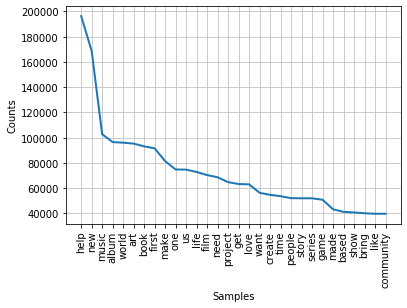

In [29]:
cfdist.plot(30,cumulative=False)

# Subset df into multiple df
- remove columns
- subset by category

In [123]:
df_slim = df[['name', 'blurb','pledged','state', 'currency_symbol', 'backers_count','category.name', 'urls.web.project', 'stripblurb']]

In [124]:
df_slim.sample(3)

,name,blurb,pledged,state,currency_symbol,backers_count,category.name,urls.web.project,stripblurb
1059513,White Out - Playable Art for iPhone,Opening a door to new a genre of artistic gami...,525.00,successful,$,16,Mobile Games,https://www.kickstarter.com/projects/829882389...,"[opening, door, new, genre, artistic, gaming, ..."
20368,1love2theworld: Spread love one shirt at a time.,Hello World. What im creating is my gift to th...,1.00,failed,$,1,Apparel,https://www.kickstarter.com/projects/1love2the...,"[hello, world, im, creating, gift, world, ’, c..."
1511643,Project 2525: The World Speed Project Bus Conv...,"After purchasing it's very own bus in 2012, th...",3069.67,successful,$,205,Conceptual Art,https://www.kickstarter.com/projects/525486515...,"[purchasing, bus, 2012, world, speed, project,..."


In [48]:
df_slim['category.name'].unique()

array(['Rock', 'Mixed Media', 'Photobooks', 'Software', 'Nonfiction',
       'Sculpture', 'Playing Cards', 'Fine Art', 'Restaurants', 'Nature',
       'Festivals', 'Classical Music', 'Small Batch', 'Musical',
       'Accessories', 'Country & Folk', 'Plays', 'Apparel', 'Footwear',
       'R&B', 'Pop', 'Jazz', 'Experimental', 'Photography',
       'Performance Art', 'Music', 'Places', 'Comedy', 'Animals',
       'Indie Rock', 'Theater', 'People', 'Immersive', 'Crafts', 'Spaces',
       'Faith', 'Fashion', 'Jewelry', 'Art Books', 'Hardware', 'Couture',
       'Web', 'Farms', 'Drama', 'Mobile Games', 'Tabletop Games',
       'Electronic Music', 'Video', 'Live Games', 'Radio & Podcasts',
       'Horror', 'DIY Electronics', 'Metal', 'Journalism', 'Webcomics',
       'Print', 'Audio', 'Space Exploration', 'Events', 'Technology',
       '3D Printing', 'Apps', 'Photo', 'Gadgets', 'Candles',
       'Childrenswear', 'Workshops', 'Graphic Design', 'Narrative Film',
       'Performances', 'Taxiderm

In [49]:
from collections import Counter

In [50]:
catDict = Counter(df_slim['category.name'])
catDict

Counter({'Rock': 28004,
         'Mixed Media': 24552,
         'Photobooks': 12868,
         'Software': 19754,
         'Nonfiction': 24574,
         'Sculpture': 19485,
         'Playing Cards': 20065,
         'Fine Art': 6973,
         'Restaurants': 23416,
         'Nature': 4760,
         'Festivals': 6663,
         'Classical Music': 25357,
         'Small Batch': 20322,
         'Musical': 8626,
         'Accessories': 18722,
         'Country & Folk': 27966,
         'Plays': 12145,
         'Apparel': 20573,
         'Footwear': 7241,
         'R&B': 5421,
         'Pop': 26237,
         'Jazz': 21844,
         'Experimental': 8131,
         'Photography': 10333,
         'Performance Art': 22988,
         'Music': 7174,
         'Places': 5741,
         'Comedy': 23542,
         'Animals': 1995,
         'Indie Rock': 29082,
         'Theater': 13843,
         'People': 9131,
         'Immersive': 3257,
         'Crafts': 12039,
         'Spaces': 8561,
         'Faith': 12

In [125]:
df_slim.to_pickle('df_slim.pkl')

In [6]:
cat_dict = {'Public Art': 'Art/Visual Art/Photography',
'Fiction': 'Art/Visual Art/Photography',
'Illustration': 'Art/Visual Art/Photography',
'Conceptual Art': 'Art/Visual Art/Photography',
'Art': 'Art/Visual Art/Photography',
'Glass': 'Art/Visual Art/Photography',
'Sculpture': 'Art/Visual Art/Photography',
'Fine Art':'Art/Visual Art/Photography',
'Printing':'Art/Visual Art/Photography',
'Painting': 'Art/Visual Art/Photography',
'Photography': 'Art/Visual Art/Photography',
'Photo': 'Art/Visual Art/Photography',
'Comic Books': 'Books/Zine/Print',
"Children's Books": 'Books/Zine/Print',
'Cookbooks': 'Books/Zine/Print',
'Graphic Novels': 'Books/Zine/Print',
'Poetry': 'Books/Zine/Print',
'Zines': 'Books/Zine/Print',
'Webcomics': 'Books/Zine/Print',
'Comics': 'Books/Zine/Print',
'Print': 'Books/Zine/Print',
'Photobooks': 'Books/Zine/Print',
'Nonfiction': 'Books/Zine/Print',
'Art Books': 'Books/Zine/Print',
'Anthologies': 'Books/Zine/Print',
'Publishing': 'Books/Zine/Print',
'Literary Journals': 'Books/Zine/Print',
'Periodicals': 'Books/Zine/Print',
'Crafts': 'Crafts/Textiles',
'Candles': 'Crafts/Textiles',
'Embroidery': 'Crafts/Textiles',
'Ceramics': 'Crafts/Textiles',
'Crochet': 'Crafts/Textiles',
'Pottery': 'Crafts/Textiles',
'Textiles': 'Crafts/Textiles',
'Weaving': 'Crafts/Textiles',
'Knitting': 'Crafts/Textiles',
'Quilts': 'Crafts/Textiles',
'Graphic Design': 'Design/Architecture',
'Civic Design': 'Design/Architecture',
'Interactive Design': 'Design/Architecture',
'Product Design': 'Design/Architecture',
'Design': 'Design/Architecture',
'Typography': 'Design/Architecture',
'Architecture': 'Design/Architecture',
'Workshops': 'Equipment/Tools/DIY',
'Fabrication Tools': 'Equipment/Tools/DIY',
'Woodworking': 'Equipment/Tools/DIY',
'DIY': 'Equipment/Tools/DIY',
'Camera Equipment': 'Equipment/Tools/DIY',
'Hardware': 'Equipment/Tools/DIY',
'DIY Electronics': 'Equipment/Tools/DIY',
'Accessories': 'Fashion/Apparel',
'Apparel': 'Fashion/Apparel',
'Footwear': 'Fashion/Apparel',
'Fashion': 'Fashion/Apparel',
'Jewelry': 'Fashion/Apparel',
'Couture': 'Fashion/Apparel',
'Childrenswear': 'Fashion/Apparel',
'Ready-to-wear': 'Fashion/Apparel',
'Restaurants': 'Food/Beverage',
'Farms': 'Food/Beverage',
'Food': 'Food/Beverage',
'Drinks': 'Food/Beverage',
'Vegan': 'Food/Beverage',
'Food Trucks': 'Food/Beverage',
"Farmer's Markets": 'Food/Beverage',
'Bacon': 'Food/Beverage',
'Small Batch': 'Food/Beverage',
'Live Games': 'Games/Gaming',
'Playing Cards': 'Games/Gaming',
'Mobile Games': 'Games/Gaming',
'Tabletop Games': 'Games/Gaming',
'Video Games': 'Games/Gaming',
'Games': 'Games/Gaming',
'Gaming Hardware': 'Games/Gaming',
'Puzzles': 'Games/Gaming',
'Audio': 'Media',
'Sound': 'Media',
'Mixed Media': 'Media',
'Radio & Podcasts': 'Media',
'Journalism': 'Media',
'Digital Art': 'Media',
'Installations': 'Media',
'Video Art': 'Media',
'Video': 'Media',
'Rock': 'Music',
'Classical Music': 'Music',
'Country & Folk': 'Music',
'R&B': 'Music',
'Pop': 'Music',
'Jazz': 'Music',
'Music': 'Music',
'Indie Rock': 'Music',
'Electronic Music': 'Music',
'Metal': 'Music',
'Hip-Hop': 'Music',
'World Music': 'Music',
'Punk': 'Music',
'Blues': 'Music',
'Nature': 'Other',
'Community Gardens': 'Other',
'Stationery': 'Other',
'Experimental': 'Other',
'Immersive': 'Other',
'Space Exploration': 'Other',
'Taxidermy': 'Other',
'Calendars': 'Other',
'Residencies': 'Other',
'Flight': 'Other',
'Latin': 'Other',
'Academic': 'Other',
'Fantasy': 'Other',
'Romance': 'Other',
'Translations': 'Other',
'Chiptune': 'Other',
'Letterpress': 'Other',
'Pet Fashion': 'Other',
'Kids': 'Other',
'Animals': 'Other',
'People': 'Other',
'Family': 'Other',
'Young Adult': 'Other',
'Faith': 'Other',
'Musical': 'Performance Art',
'Plays': 'Performance Art',
'Performance Art': 'Performance Art',
'Comedy': 'Performance Art',
'Theater': 'Performance Art',
'Performances': 'Performance Art',
'Dance': 'Performance Art',
'Festivals': 'Spaces/Places/Events',
'Literary Spaces': 'Spaces/Places/Events',
'Makerspaces': 'Spaces/Places/Events',
'Places': 'Spaces/Places/Events',
'Spaces': 'Spaces/Places/Events',
'Events': 'Spaces/Places/Events',
'Software': 'Tech/Web',
'Technology': 'Tech/Web',
'D Printing': 'Tech/Web',
'Gadgets': 'Tech/Web',
'Robots': 'Tech/Web',
'Wearables': 'Tech/Web',
'Web': 'Tech/Web',
'Apps': 'Tech/Web',
'Animation': 'Tech/Web',
'Horror': 'TV/Film/Webseries',
'Narrative Film': 'TV/Film/Webseries',
'Shorts': 'TV/Film/Webseries',
'Film & Video': 'TV/Film/Webseries',
'Drama': 'TV/Film/Webseries',
'Television': 'TV/Film/Webseries',
'Movie Theaters': 'TV/Film/Webseries',
'Documentary': 'TV/Film/Webseries',
'Science Fiction': 'TV/Film/Webseries',
'Action': 'TV/Film/Webseries',
'Thrillers': 'TV/Film/Webseries',
'Webseries': 'TV/Film/Webseries',
'Music Videos': 'TV/Film/Webseries'}

In [7]:
df_slim['newcat'] = df_slim['category.name'].map(cat_dict)

RangeIndex(start=0, stop=1668216, step=1)

In [130]:
df_music = df_slim[df_slim['newcat'] == 'Music']
df_art = df_slim[df_slim['newcat'] == 'Art/Visual Art/Photography']
df_book = df_slim[df_slim['newcat'] == 'Books/Zine/Print']
df_perform = df_slim[df_slim['newcat'] == 'Performance Art']
df_other = df_slim[df_slim['newcat'] == 'Other']
df_tech = df_slim[df_slim['newcat'] == 'Tech/Web']
df_film = df_slim[df_slim['newcat'] == 'TV/Film/Webseries']
df_games = df_slim[df_slim['newcat'] == 'Games/Gaming']
df_craft = df_slim[df_slim['newcat'] == 'Crafts/Textiles']
df_design = df_slim[df_slim['newcat'] == 'Design/Architecture']
df_diy = df_slim[df_slim['newcat'] == 'Equipment/Tools/DIY']
df_fashion = df_slim[df_slim['newcat'] == 'Fashion/Apparel']
df_food = df_slim[df_slim['newcat'] == 'Food/Beverage']
df_media = df_slim[df_slim['newcat'] == 'Media']
df_events = df_slim[df_slim['newcat'] == 'Spaces/Places/Events']

In [132]:
df_music.head(5)

,name,blurb,pledged,state,currency_symbol,backers_count,category.name,urls.web.project,stripblurb,newcat
0,New Final Round Album,2006 was almost 7 years ago.... Can you believ...,802.0,successful,$,21,Rock,https://www.kickstarter.com/projects/149592564...,"[2006, almost, 7, years, ago, believe, fast, t...",Music
15,PiE presents the Lyris Quartet in Concert,"Called ""focused. penetrating. radiant."", the L...",25.0,failed,$,1,Classical Music,https://www.kickstarter.com/projects/pielectro...,"[called, focused, penetrating, radiant, lyris,...",Music
21,Aaron's FIRST Full-Length Album,"These songs have been with me for years, and i...",1791.0,successful,$,46,Country & Folk,https://www.kickstarter.com/projects/aaronsimm...,"[songs, years, finally, time, share, best, work]",Music
22,New EP,We've worked hard over the past months to crea...,515.0,successful,$,12,Rock,https://www.kickstarter.com/projects/winnertak...,"[worked, hard, past, months, create, new, song...",Music
23,The Road to Carnegie Hall,The Virginia Tech Wind Ensemble is traveling t...,3309.2,successful,$,77,Classical Music,https://www.kickstarter.com/projects/vtswe/the...,"[virginia, tech, wind, ensemble, traveling, ca...",Music


In [133]:
df_art = df_art.reset_index(drop = True)

In [134]:
df_music = df_music.reset_index(drop = True)

In [135]:
df_book = df_book.reset_index(drop = True)

In [136]:
df_perform = df_perform.reset_index(drop = True)

In [137]:
df_other = df_other.reset_index(drop = True) 

In [138]:
df_tech = df_tech.reset_index(drop = True) 

In [139]:
df_film = df_film.reset_index(drop = True) 

In [140]:
df_games = df_games.reset_index(drop = True) 

In [141]:
df_craft = df_craft.reset_index(drop = True) 

In [142]:
df_design = df_design.reset_index(drop = True) 

In [143]:
df_diy = df_diy.reset_index(drop = True) 

In [144]:
df_fashion = df_fashion.reset_index(drop = True)

In [145]:
df_food = df_food.reset_index(drop = True) 

In [146]:
df_media = df_media.reset_index(drop = True) 

In [147]:
df_events = df_events.reset_index(drop = True)

In [148]:
df_fashion.index

RangeIndex(start=0, stop=78723, step=1)

In [149]:
df_art.to_pickle('df_art.pkl') 
df_book.to_pickle('df_book.pkl')
df_perform.to_pickle('df_perform.pkl')
df_other.to_pickle('df_other.pkl')
df_tech.to_pickle('df_tech.pkl') 
df_film.to_pickle('df_film.pkl')
df_games.to_pickle('df_games.pkl')
df_craft.to_pickle('df_craft.pkl')
df_design.to_pickle('df_design.pkl') 
df_diy.to_pickle('df_diy.pkl')
df_fashion.to_pickle('df_fashion.pkl')
df_food.to_pickle('df_food.pkl')
df_media.to_pickle('df_media.pkl')
df_events.to_pickle('df_events.pkl')
df_music.to_pickle('df_music.pkl') 

## Use Google News corpus to train word embeddings

In [10]:
import gensim
from gensim.models import KeyedVectors

In [165]:
# Load vectors directly from the file
filename = 'GoogleNews-vectors-negative300-SLIM.bin'
emb_model = KeyedVectors.load_word2vec_format(filename, binary=True)

In [11]:
norm_model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300-SLIM.bin', binary=True)
norm_model.init_sims(replace=True)

In [199]:
# For word in list, get embedding, return all vectors"""
def get_vectors(listcol):
    vectors = []
    for word in listcol: 
        try:
            vector = emb_model[word]
            vectors.append(vector)
        except KeyError: 
            pass
    return vectors

In [206]:
# For word in list, get embedding, return all vectors"""
def get_vectors_norm(listcol):
    nvectors = []
    for word in listcol: 
        try:
            nvector = norm_model[word]
            nvectors.append(nvector)
        except KeyError: 
            pass
    return nvectors

In [207]:
# apply vectors to the stripped, tokenized text
df_art['nvectors'] = df_art['stripblurb'].apply(get_vectors_norm)
df_book['nvectors'] = df_book['stripblurb'].apply(get_vectors_norm)
df_craft['nvectors'] = df_craft['stripblurb'].apply(get_vectors_norm)
df_design['nvectors'] = df_design['stripblurb'].apply(get_vectors_norm)
df_diy['nvectors'] = df_diy['stripblurb'].apply(get_vectors_norm)
df_events['nvectors'] = df_events['stripblurb'].apply(get_vectors_norm)
df_fashion['nvectors'] = df_fashion['stripblurb'].apply(get_vectors_norm)
df_food['nvectors'] = df_food['stripblurb'].apply(get_vectors_norm)
df_film['nvectors'] = df_film['stripblurb'].apply(get_vectors_norm)
df_media['nvectors'] = df_media['stripblurb'].apply(get_vectors_norm)
df_music['nvectors'] = df_music['stripblurb'].apply(get_vectors_norm)
df_perform['nvectors'] = df_perform['stripblurb'].apply(get_vectors_norm)
df_tech['nvectors'] = df_tech['stripblurb'].apply(get_vectors_norm)
df_other['nvectors'] = df_other['stripblurb'].apply(get_vectors_norm)
df_games['nvectors'] = df_games['stripblurb'].apply(get_vectors_norm)

In [ ]:
df_art.to_pickle('df_art_vec.pkl') 
df_book.to_pickle('df_book_vec.pkl')
df_perform.to_pickle('df_perform_vec.pkl')
df_other.to_pickle('df_other_vec.pkl')
df_tech.to_pickle('df_tech_vec.pkl') 
df_film.to_pickle('df_film_vec.pkl')
df_games.to_pickle('df_games_vec.pkl')
df_craft.to_pickle('df_craft_vec.pkl')
df_design.to_pickle('df_design_vec.pkl') 
df_diy.to_pickle('df_diy_vec.pkl')
df_fashion.to_pickle('df_fashion_vec.pkl')
df_food.to_pickle('df_food_vec.pkl')
df_media.to_pickle('df_media_vec.pkl')
df_events.to_pickle('df_events_vec.pkl')
df_music.to_pickle('df_music_vec.pkl')

## Test and train 2 different models
- CBOW
- Skip Gram

In [12]:
from sklearn.model_selection import train_test_split

In [65]:
train, test = train_test_split(df_slim, test_size=0.2)

In [66]:
# Create CBOW model 
cbowmodel = gensim.models.Word2Vec(train['stripblurb'], min_count = 1,  
                              size = 100, window = 5) 

In [67]:
# Create Skip Gram model 
sgmodel = gensim.models.Word2Vec(train['stripblurb'], min_count = 1, size = 100, 
                                             window = 5, sg = 1) 

In [68]:
print(cbowmodel)

Word2Vec(vocab=88659, size=100, alpha=0.025)


In [69]:
print(sgmodel)

Word2Vec(vocab=88659, size=100, alpha=0.025)


In [42]:
words = list(model1.wv.vocab)

In [43]:
print(words)

['we', 'are', 'looking', 'to', 'expand', 'our', 'podcast', 'allow', 'for', 'guests', ',', 'this', 'requires', 'another', 'mic', 'otherwise', 'how', 'will', 'ryan', 'interview', 'bailey', 'jay', 'through', 'a', 'global', 'conflict', 'in', 'small', 'fishing', 'town', 'japan', 'the', 'film', 'offers', 'new', 'insights', 'towards', 'whale', 'dolphin', 'controversy', '.', 'is', '300', 'plus', 'year', 'fictional', 'tale', 'of', 'gabriel', 'trottier', 'and', 'secret', 'why', 'detroit', 'was', 'founded', 'he', 'still', 'protecting', 'it', 'today', '...', 'light', 'up', 'gmf', 'aquarium', 'ornaments', 'seconds', 'no', 'wires', 'or', 'electricity', 'inside', 'tank', 'interactive', 'sound', 'motion', 'bubbles', 'mobile', 'app', 'exclusive', 'pre-sale', 'get', 'now', 'before', 'springtime', 'release', 'adult', 'illiteracy', 'easy', 'ignore', 'book', 'reveals', 'stories', 'dreams', 'that', 'un-relatable', 'familiar', 'all', 'at', 'once', 'lil', 'draggo', 'pin', 'be', '1.25', 'cloisonné', 'hard', 'e

In [18]:
cbowmodel.wv.save_word2vec_format('cbowmodel.bin')

In [19]:
sgmodel.wv.save_word2vec_format('sgmodel.bin')

In [ ]:
# import python wrapper for earth mover distance
from pyemd import emd

In [ ]:
df['distance'] = 0
for n in range(len(df)):
    distance = emb_model.wmdistance(clean_input, df.loc[n,'stripblurb'])
    df.loc[n,'distance'] = distance

In [ ]:
# Test pre-trained model
# input_list = []
#     for i in appdf_sub['cleanblurb']:
#         distance = emb_model.wmdistance(clean_input, i)
#         input_list.append(distance)

In [ ]:
# Test CBOW model

In [ ]:
# Test Skip Gram model

In [70]:
test = test.reset_index(drop = True)

## Validate and test function that calculates distances and outputs responses
- Output histogram of distances for non-normed vs normed pre-trained models
- Output histogram of distances for CBOW vs skip gram models

In [71]:
def pretrain():
    # accept user input
    text = input("Pitch your idea here: ")
    
    # clean and tokenize user input
    clean_input = stripper(text)
        
    # calculate WMD distance
    test['distance'] = 0
    
    for n in range(len(test)):
        distance = norm_model.wmdistance(clean_input, test.loc[n,'stripblurb'])
        test.loc[n,'distance'] = distance
        
    
#     # sort dataframe in ascending order by distance
#     df_craft.sort_values(by=['distance'])
    
#     # return url for top 3 rows
#     for i in df_craft['state']:
#         if i == 'successful':
#             return print(appdf_sub['projecturls'].head(3))
    


In [72]:
pretrain()

Pitch your idea here:  crafting hand-knit hats from recycled yarn


In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

In [73]:
test['distance'].describe()

count    3.336440e+05
mean              inf
std               NaN
min      8.168830e-01
25%      1.292047e+00
50%      1.306490e+00
75%      1.318519e+00
max               inf
Name: distance, dtype: float64

In [75]:
def cbow_train():
    # accept user input
    text = input("Pitch your idea here: ")
    
    # clean and tokenize user input
    clean_input = stripper(text)
    
#      # get vectors for input text
#     clean_input['nvectors'] = clean_input.apply(get_vectors)
    
    # calculate WMD distance
    test['dist_cbow'] = 0
    
    for n in range(len(test)):
        dist_cbow = cbowmodel.wmdistance(clean_input, test.loc[n,'stripblurb'])
        test.loc[n,'dist_cbow'] = dist_cbow

In [76]:
cbow_train()

Pitch your idea here:  crafting hand-knit hats from recycled yarn


/anaconda3/envs/insight/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `wmdistance` (Method will be removed in 4.0.0, use self.wv.wmdistance() instead).
  from ipykernel import kernelapp as app


In [88]:
test['dist_cbow'].describe()

count    3.336440e+05
mean              inf
std               NaN
min      1.080697e+01
25%      1.996559e+01
50%      2.088520e+01
75%      2.175922e+01
max               inf
Name: dist_cbow, dtype: float64

In [78]:
def sg_train():
    # accept user input
    text = input("Pitch your idea here: ")
    
    # clean and tokenize user input
    clean_input = stripper(text)
    
#      # get vectors for input text
#     clean_input['nvectors'] = clean_input.apply(get_vectors)
    
    # calculate WMD distance
    test['dist_sg'] = 0
    
    for n in range(len(test)):
        dist_sg = sgmodel.wmdistance(clean_input, test.loc[n,'stripblurb'])
        test.loc[n,'dist_sg'] = dist_sg

In [79]:
sg_train()

Pitch your idea here:  crafting hand-knit hats from recycled yarn


/anaconda3/envs/insight/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `wmdistance` (Method will be removed in 4.0.0, use self.wv.wmdistance() instead).
  from ipykernel import kernelapp as app


In [89]:
test['dist_sg'].describe()

count    3.336440e+05
mean              inf
std               NaN
min      3.266955e+00
25%      5.051066e+00
50%      5.176227e+00
75%      5.304918e+00
max               inf
Name: dist_sg, dtype: float64

In [82]:
test_noinf = test[test.replace([np.inf, -np.inf], np.nan).notnull().all(axis=1)]

In [90]:
test_norm = test[np.isfinite(test['distance'])]

In [91]:
test_norm['distance'].describe()

count    333544.000000
mean          1.301923
std           0.029592
min           0.816883
25%           1.292044
50%           1.306484
75%           1.318509
max           1.446470
Name: distance, dtype: float64

In [92]:
test_cbow = test[np.isfinite(test['dist_cbow'])]

In [93]:
test_cbow['dist_cbow'].describe()

count    333623.000000
mean         20.828657
std           1.385532
min          10.806969
25%          19.965520
50%          20.885163
75%          21.759030
max          29.958161
Name: dist_cbow, dtype: float64

In [94]:
test_sg = test[np.isfinite(test['dist_sg'])]

In [95]:
test_sg['dist_sg'].describe()

count    333623.000000
mean          5.176221
std           0.204721
min           3.266955
25%           5.051064
50%           5.176213
75%           5.304902
max           6.522509
Name: dist_sg, dtype: float64

In [83]:
test_noinf['distance'].describe()

count    332530.000000
mean          1.301936
std           0.029594
min           0.816883
25%           1.292058
50%           1.306499
75%           1.318520
max           1.446470
Name: distance, dtype: float64

In [85]:
test_noinf['dist_cbow'].describe()

count    332530.000000
mean         20.832178
std           1.383565
min          10.806969
25%          19.969492
50%          20.888304
75%          21.761311
max          29.958161
Name: dist_cbow, dtype: float64

In [87]:
test_noinf['dist_sg'].describe()

count    332530.000000
mean          5.176442
std           0.204604
min           3.266955
25%           5.051280
50%           5.176425
75%           5.305089
max           6.522509
Name: dist_sg, dtype: float64

AttributeError: module 'seaborn' has no attribute 'plt'

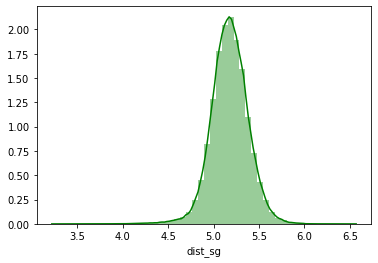

In [100]:
# sns.distplot(test_noinf['distance'], color="blue", label="Normalized Distance")
# sns.distplot(test_noinf["dist_cbow"], color="red", label="CBOW Distance")
sns.distplot(test_noinf["dist_sg"], color="green", label="SG Distance")
sns.plt.legend()
 

ValueError: supplied range of [0.0, inf] is not finite

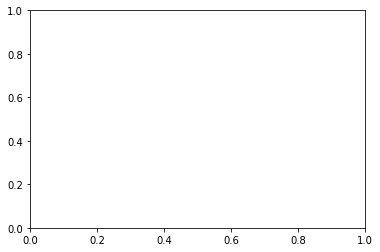

In [163]:
import random
import numpy
from matplotlib import pyplot

x = [random.gauss(3,1) for _ in range(400)]
y = [random.gauss(4,2) for _ in range(400)]

bins = numpy.linspace(-10, 10, 100)

pyplot.hist(x, bins, alpha=0.5, label='x')
pyplot.hist(y, bins, alpha=0.5, label='y')
pyplot.legend(loc='upper right')
pyplot.show()

In [165]:
my_str1 = "Crafting eco-friendly shoes from materials recycled from the ocean"
my_str2 = "A new album by the Killer Bees taking experimental sound to the next level"

In [ ]:
# convert unix time to utc
# import datetime
# date = datetime.datetime.fromtimestamp(customTimestamp)
# print(date.strftime('%Y-%m-%d %H:%M:%S'))